In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

WALL_CELL_CONTENT = 1
FREE_CELL_CONTENT = 0

# IA - Labyrinth

In [2]:
def generate_labyrinth(width, height, wall_ratio=0.3):
    """ Randomly generates the labyrinth matrix, the values are:
    0 if the cell is free
    1 if there is a wall
    :param width int: width of the matrix
    :param height int: height of the matrix
    :wall_ratio float: chance for a cell to be a wall
    :return: tuple composed of:
    <matrix>: numpy 2d array
    <start_cell>: tuple of i, j indices for the start cell
    <end_cell>: tuple of i, j indices for the end cell
    """
    grid = np.random.rand(width, height)
    grid[grid >= 1 - wall_ratio] = 1
    grid[grid < 1 - wall_ratio] = 0
    free_cell_top = [i for i in range(0, width) if grid[0][i] != 1]
    start_idx = random.choice(free_cell_top)
    start_cell = (0, start_idx)
    free_cell_bottom = [i for i in range(0, width) if grid[-1][i] != 1]
    end_idx = random.choice(free_cell_bottom)
    end_cell = (height - 1, end_idx)
    return grid, start_cell, end_cell

In [3]:
def display_labyrinth(grid, start_cell, end_cell, solution=None):
    """ Display the labyrinth matrix and possibly the solution with matplotlib.
    Free cell will be in light gray.
    Wall cells will be in dark gray.
    Start and end cells will be in dark blue.
    Path cells (start, end excluded) will be in light blue.
    :param grid np.array: labyrinth matrix
    :param start_cell: tuple of i, j indices for the start cell
    :param end_cell: tuple of i, j indices for the end cell
    :param solution: list of successive tuple i, j indices who forms the path
    """
    grid = np.array(grid, copy=True)
    START = 0
    END = 0
    PATH = 2
    WALL_CELL = 16
    FREE_CELL = 19
    grid[grid == 0] = FREE_CELL
    grid[grid == 1] = WALL_CELL
    grid[start_cell] = START
    grid[end_cell] = END
    if solution:
        solution = solution[1:-1]
        for cell in solution:
            grid[cell] = PATH
    else:
        print("No solution has been found")
    plt.matshow(grid, cmap="tab20c")

In [4]:
grid, start_cell, end_cell = generate_labyrinth(10, 10)

No solution has been found
[[1. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
 [1. 0. 0. 1. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]]
(0, 1)
1.0


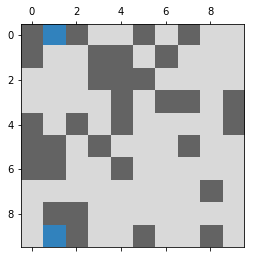

In [5]:
display_labyrinth(grid, start_cell, end_cell)
print(grid)
print(start_cell)
print(grid[(2,3)])

# Imports
        

In [6]:
from deap import base
from deap import creator
from deap import tools 
from deap import algorithms
import random
from enum import Enum
from collections import namedtuple

# Data Structure

In [7]:
CODE_LENGTH = 2 # EACH CODE HAS 2 bits, 4 possibilities (left, right, top, bottom)
NB_DIRECTIONS = 20
CHROMOSOM_LENGTH = CODE_LENGTH * NB_DIRECTIONS
    
class DirectionEnum(Enum):
    TOP = 0
    RIGHT = 1
    BOTTOM = 2
    LEFT = 3

Direction = namedtuple("Direction", ["direction", "str"])


# Useful functions

In [8]:
def direction_to_str(direction):
    return direction.str

def _parse_code(code):
    int_value = int(code, 2)
    return Direction(DirectionEnum(int_value), DirectionEnum(int_value).name[0])

def _decode(individual):
    chromosome_str = "".join([str(gene) for gene in individual])
    directions = [_parse_code(chromosome_str[i: i + CODE_LENGTH]) for i in range(0, len(chromosome_str), CODE_LENGTH)]
    return directions

def display_chromosome(individual):
    return " ".join(direction_to_str(d) for d in _decode(individual))

# todo : map
def compute_chromosome(individual, labyrinth, start, end, debug = False):
    directions = _decode(individual) 
    x, y = start[0], start[1]
    result = [start]
    
    if debug:
        print(x,y)
    
    for direction in directions:
        if debug:
            print(f'x,y : {(x,y)}')
            print(direction.direction)
        if direction.direction == DirectionEnum.TOP and x-1 > 0 and grid[(x-1,y)] == FREE_CELL_CONTENT:
            x -= 1
            result.append((x, y))
        elif direction.direction == DirectionEnum.RIGHT and y+1 < grid.shape[1] and grid[(x,y+1)] == FREE_CELL_CONTENT:
            y += 1
            result.append((x, y))
        elif direction.direction == DirectionEnum.BOTTOM and x+1 < grid.shape[0] and grid[(x+1,y)] == FREE_CELL_CONTENT:
            x += 1
            result.append((x,y))
        elif direction.direction == DirectionEnum.LEFT and y-1 > 0 and grid[(x,y-1)] == FREE_CELL_CONTENT:
            y -= 1
            result.append((x,y))
    
    return result

def difference_x(p1, p2):
    return abs(p1[0]-p2[0])

def difference_y(p1, p2):
    return abs(p1[1]-p2[1])

def manhattan(p1, p2):
    return difference_x(p1, p2)+difference_y(p1, p2)

# Deap

In [9]:
toolbox = base.Toolbox()

In [10]:
def fitness(individual, grid, start_cell, end_cell):
    path = compute_chromosome(individual, grid, start_cell, end_cell)
    return (manhattan(end_cell, path[-1]) + (20 - len(path)),)


toolbox.register("fitness", fitness)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin) 

toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
toolbox.register("select", tools.selRoulette)

toolbox.register("init_gene", random.randint, 0, 1)
toolbox.register("init_individual", tools.initRepeat, creator.Individual, toolbox.init_gene, CHROMOSOM_LENGTH)
toolbox.register("init_population", tools.initRepeat, list, toolbox.init_individual)

## Solve

In [11]:
def evaluate_population(population, grid, start_cell, end_cell):
    fitnesses = [toolbox.fitness(ind, grid, start_cell, end_cell) for ind in population]
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

# TODO MAP FILTER POUR OPTI
def find_winners(population, grid, start_cell, end_cell):
    winners = []
    
    for individual in population:
        path = compute_chromosome(individual, grid, start_cell, end_cell)
        if path[-1] == end_cell:
            winners.append(individual)
    
    return winners

def solve_labyrinth(grid, start_cell, end_cell, max_time_s):
    N_POPULATION = 50
    CROSSOVER_PROBA = 0.7
    MUTATE_PROBA = 0.1
    
    start_time = inter_time = time.time()
    population = toolbox.init_population(n = N_POPULATION)

    evaluate_population(population, grid, start_cell, end_cell)
    solution = None

    number_of_iterations = 0
    while len(find_winners(population, grid, start_cell, end_cell)) == 0 and inter_time - start_time < max_time_s:
        children = toolbox.select(population, len(population))

        children = list(map(toolbox.clone, children))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(children[::2], children[1::2]):
            if random.random() < CROSSOVER_PROBA:
                toolbox.mate(child1, child2)            

        for mutant in children:
            # add a new component
            if random.random() < MUTATE_PROBA:
                toolbox.mutate(mutant)

        evaluate_population(children, grid, start_cell, end_cell)
        population = children

        # Search for the solution
        fitnesses = [ind.fitness.values[0] for ind in population]
        min_fit = min(fitnesses)
        best = population[fitnesses.index(min_fit)]
        if not solution or best.fitness.values[0] < solution.fitness.values[0]:
            solution = best

        inter_time = time.time()
        
    path = compute_chromosome(population[0], grid, start_cell, end_cell)
    display_labyrinth(grid, start_cell, end_cell, path)
    
    return find_winners(population, grid, start_cell, end_cell)


L T L L R L R B T T T T T R L B T L T R
0 1
x,y : (0, 1)
DirectionEnum.LEFT
x,y : (0, 1)
DirectionEnum.TOP
x,y : (0, 1)
DirectionEnum.LEFT
x,y : (0, 1)
DirectionEnum.LEFT
x,y : (0, 1)
DirectionEnum.RIGHT
x,y : (0, 1)
DirectionEnum.LEFT
x,y : (0, 1)
DirectionEnum.RIGHT
x,y : (0, 1)
DirectionEnum.BOTTOM
x,y : (1, 1)
DirectionEnum.TOP
x,y : (1, 1)
DirectionEnum.TOP
x,y : (1, 1)
DirectionEnum.TOP
x,y : (1, 1)
DirectionEnum.TOP
x,y : (1, 1)
DirectionEnum.TOP
x,y : (1, 1)
DirectionEnum.RIGHT
x,y : (1, 2)
DirectionEnum.LEFT
x,y : (1, 1)
DirectionEnum.BOTTOM
x,y : (2, 1)
DirectionEnum.TOP
x,y : (1, 1)
DirectionEnum.LEFT
x,y : (1, 1)
DirectionEnum.TOP
x,y : (1, 1)
DirectionEnum.RIGHT
[(0, 1), (1, 1), (1, 2), (1, 1), (2, 1), (1, 1), (1, 2)]
None
No solution has been found


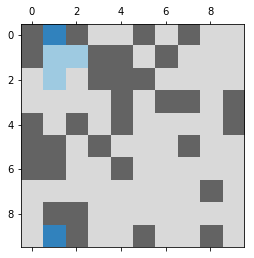

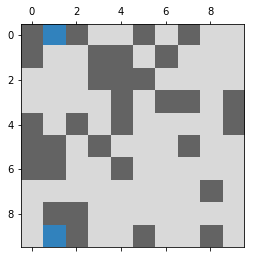

In [12]:
winners = solve_labyrinth(grid, start_cell, end_cell, 5)

solution = None

if len(winners):
    solution = compute_chromosome(winners[0])
    
display_labyrinth(grid, start_cell, end_cell, solution)